In [402]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
datasetname='2nd-CuSn-FE-HCOOHCO-LR.csv'
strlist = datasetname.split('.') 
savename=strlist[0]
dataset = pd.read_csv(datasetname)
print(dataset.head())
col = dataset.columns.values.tolist()
headers =col[0:-1]
features = np.array(dataset[headers])
labels = dataset['FEHCOOH/FECO']
PLOT_NAME = 'feature importance of GBDT model_'+str(savename)+'.png'
PLOT_NAME1 = 'permutation feature importance of GBDT model_'+str(savename)+'.png'
PLOT_NAME2 = 'Lasso linear model importance score of_'+str(savename)+'.png'
PLOT_NAME3 = 'linear regression importance score of_'+str(savename)+'.png'
TXT_NAME= 'dataforplot_'+str(savename)+'.txt'

   alcoholic hydroxyl   phenolic hydroxyl   sulfhydryl  aliphatic amine  \
0                    0                   0           0                1   
1                    0                   0           0                1   
2                    0                   0           0                0   
3                    0                   0           0                1   
4                    0                   1           0                0   

   aromatic amine  carboxy   pyridine   imidazole  pyrrole   triazole   cyano  \
0               0         1          0          0         0          0      0   
1               0         1          0          0         0          0      0   
2               0         0          1          0         0          0      0   
3               0         1          0          0         0          0      0   
4               0         1          0          0         0          0      0   

   phosphate   alkynyl  FEHCOOH/FECO  
0           0        0 

In [403]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [404]:
#GBR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.15, random_state=12)
cv = 5
from sklearn.ensemble import GradientBoostingRegressor
tuned_parameters = [{'learning_rate': [0.0025,0.01,0.05], 'subsample': [0.5],
                     'max_depth': [3, 5, 10], 'warm_start': [False],  'min_samples_split': [4, 5, 6],'n_estimators':[500,1000,5000]}]
gbr= GradientBoostingRegressor(verbose=0, validation_fraction=0.15)
gbr = GridSearchCV(gbr, tuned_parameters, verbose=1, scoring=None, cv=cv, n_jobs=16)
gbr.fit(X_train, y_train)
gbr_new = gbr.best_estimator_
best_p = gbr.best_params_
paras = gbr_new.get_params()
print(best_p)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    9.4s


{'learning_rate': 0.0025, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': 0.5, 'warm_start': False}


[Parallel(n_jobs=16)]: Done 405 out of 405 | elapsed:   21.7s finished


In [405]:
mse = mean_squared_error(y_test, gbr_new.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
y_pred = gbr_new.predict(X_test)
r2_score(y_test, y_pred)
print("The R2 on test set: {:.4f}".format(r2_score(y_test, y_pred)))
from sklearn.metrics import explained_variance_score
print("The  explained variance regression score on test set: {:.4f}".format(explained_variance_score(y_test, y_pred, multioutput='uniform_average')))
print("The MAE on test set: {:.4f}".format(mean_absolute_error(y_test, y_pred)))

The mean squared error (MSE) on test set: 0.3989
The R2 on test set: 0.0832
The  explained variance regression score on test set: 0.1172
The MAE on test set: 0.4744


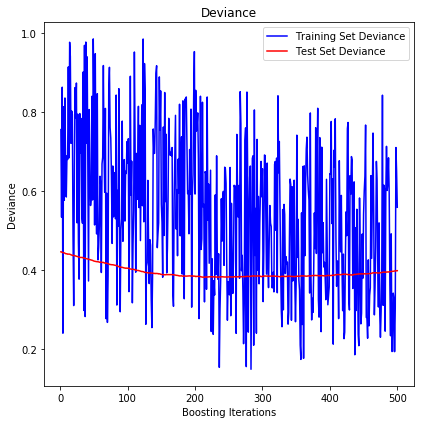

In [406]:

test_score = np.zeros((paras['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(gbr_new.staged_predict(X_test)):
    test_score[i] = gbr_new.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(paras['n_estimators']) + 1, gbr_new.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(paras['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

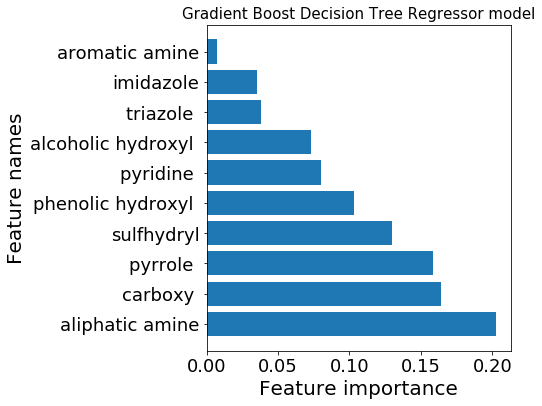

In [407]:
feature_importance = gbr_new.feature_importances_
sorted_idx = np.argsort(-feature_importance)
pos1 = np.arange(10) + .5
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.barh(pos1, feature_importance[sorted_idx[:10]], align='center')
plt.yticks(pos1, np.array(headers)[sorted_idx[:10]])
plt.title('Gradient Boost Decision Tree Regressor model',fontsize=15)

plt.xlabel('Feature importance',fontsize=20)             #设置x，y轴的标签
plt.ylabel('Feature names',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(labelsize=18)
plt.savefig(PLOT_NAME, bbox_inches='tight',dpi=600)


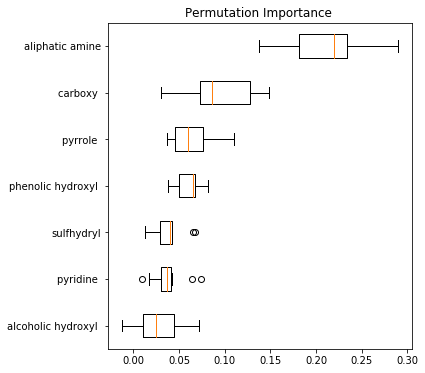

In [408]:
result = permutation_importance(gbr_new, features, labels, n_repeats=10,
                                random_state=42, n_jobs=5)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.boxplot(result.importances[sorted_idx[len(result.importances[sorted_idx])-20:len(result.importances[sorted_idx])]].T,
            vert=False, labels=np.array(headers)[sorted_idx[len(result.importances[sorted_idx])-20:len(result.importances[sorted_idx])]])
plt.title("Permutation Importance ")

plt.savefig(PLOT_NAME1, bbox_inches='tight',dpi=600)

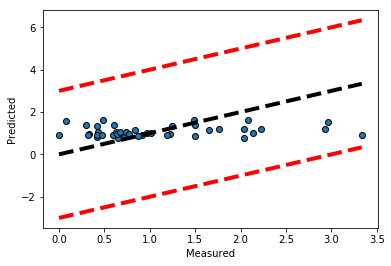

In [409]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
y=labels
predicted = cross_val_predict(gbr_new, features, labels, cv=10)
fig, ax = plt.subplots()
ax.scatter(labels, predicted, edgecolors=(0, 0, 0))
drawpiclim=3
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.plot([y.min(), y.max()], [y.min()+drawpiclim, y.max()+drawpiclim], 'r--', lw=4)
ax.plot([y.min(), y.max()], [y.min()-drawpiclim, y.max()-drawpiclim], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Coefficients: 
 [-0.          0.         -0.          0.06392937 -0.          0.
 -0.         -0.         -0.         -0.          0.         -0.
  0.        ]
Mean squared error: 0.44
Coefficient of determination（R2 score）: -0.02
The MAE on test set: 0.6014
The  explained variance regression score on test set: 0.0169
模型截距:
1.0567586674395428


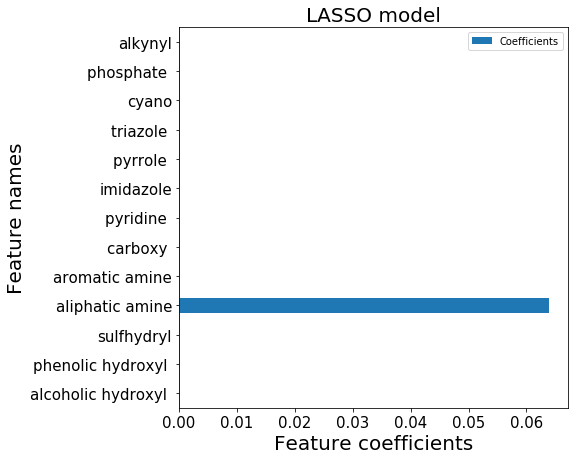

In [410]:
#Lasso
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
#localphfeature=np.array(origindata.iloc[:,:1])
clf = LassoCV().fit(X_train,y_train)

# Make predictions using the testing set
y_pred = clf.predict(X_test)

# The coefficients
print('Coefficients: \n', clf.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination（R2 score）: %.2f'
      % r2_score(y_test, y_pred))
print("The MAE on test set: {:.4f}".format(mean_absolute_error(y_test, y_pred)))
from sklearn.metrics import explained_variance_score
print("The  explained variance regression score on test set: {:.4f}".format(explained_variance_score(y_test, y_pred, multioutput='uniform_average')))
# 训练后模型截距
print('模型截距:')
print(clf.intercept_)
coefs1 = pd.DataFrame(
   clf.coef_,
    columns=['Coefficients'], index=headers
)
coefs1


coefs1.plot(kind='barh', figsize=(9, 7))
plt.title('LASSO model',fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Feature coefficients',fontsize=20)             #设置x，y轴的标签
plt.ylabel('Feature names',fontsize=20)
plt.tick_params(labelsize=15)
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)


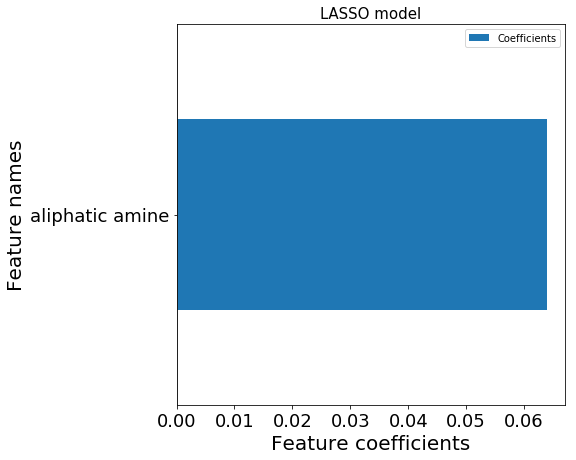

In [411]:
coefs1_copy=coefs1.iloc[[idx for idx in range(len(coefs1)) if coefs1.iloc[idx].values!=0.000 ]]
coefs1_copy.plot(kind='barh', figsize=(9, 7))
plt.title('LASSO model',fontsize=15)
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Feature coefficients',fontsize=20)             #设置x，y轴的标签
plt.ylabel('Feature names',fontsize=20)
plt.tick_params(labelsize=18)
plt.savefig(PLOT_NAME2, bbox_inches='tight',dpi=600)


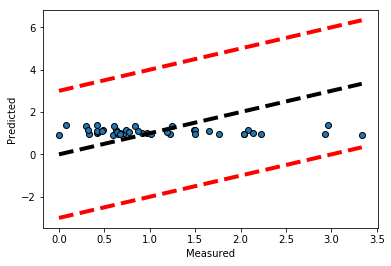

In [412]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
predicted = cross_val_predict(clf, features, labels, cv=10)
y=labels
fig, ax = plt.subplots()
ax.scatter(labels, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.plot([y.min(), y.max()], [y.min()+drawpiclim, y.max()+drawpiclim], 'r--', lw=4)
ax.plot([y.min(), y.max()], [y.min()-drawpiclim, y.max()-drawpiclim], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Coefficients: 
 [-1.96209317  0.81843885 -0.73505701  0.39588302  0.37058725 -0.5415712
 -0.7491563  -1.15582489 -0.89114966 -1.10117303  0.         -0.51483063
  0.        ]
Mean squared error: 1.99
Coefficient of determination（R2 score）: -3.58
The  explained variance regression score on test set: -3.2970
The MAE on test set: 1.0848
模型截距:
1.8622627883513003


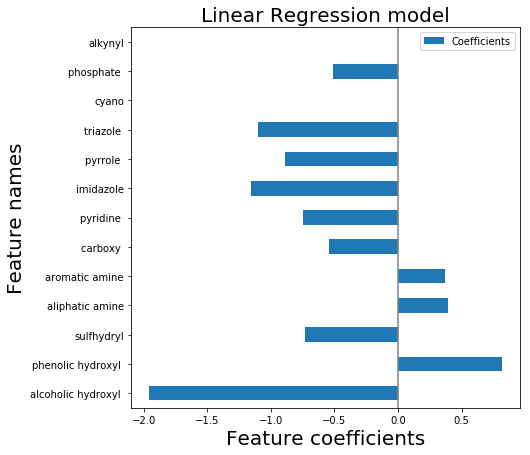

In [413]:

#linear model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

reg =linear_model.LinearRegression()
reg.fit(X_train,y_train)
#reg.fit(X_train,y_train)
# Make predictions using the testing set
y_pred = reg.predict(X_test)

# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination（R2 score）: %.2f'
      % r2_score(y_test, y_pred))
from sklearn.metrics import explained_variance_score
print("The  explained variance regression score on test set: {:.4f}".format(explained_variance_score(y_test, y_pred, multioutput='uniform_average')))
print("The MAE on test set: {:.4f}".format(mean_absolute_error(y_test, y_pred)))
# 训练后模型截距
print('模型截距:')
print(reg.intercept_)
coefs = pd.DataFrame(
   reg.coef_,
    columns=['Coefficients'], index=headers
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Linear Regression model',fontsize=20)
plt.xlabel('Feature coefficients',fontsize=20)             #设置x，y轴的标签
plt.ylabel('Feature names',fontsize=20)
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)


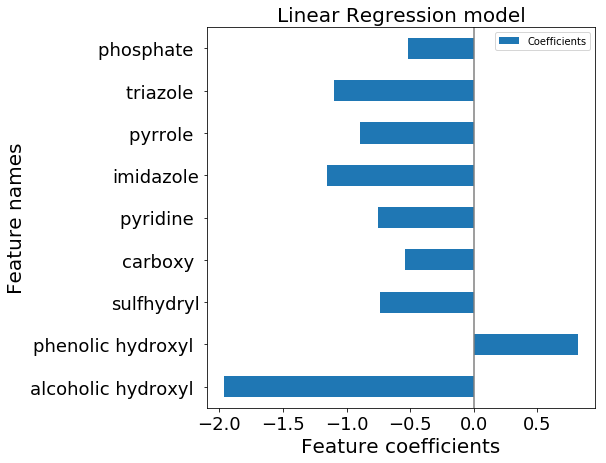

In [414]:
#coefs_copy=coefs.iloc[[idx for idx in range(len(coefs)) if coefs.iloc[idx].values>5e12 or coefs.iloc[idx].values <-5e12]]
coefs_copy=coefs.iloc[[idx for idx in range(len(coefs)) if coefs.iloc[idx].values>0.5 or coefs.iloc[idx].values <-0.5]]
coefs_copy.plot(kind='barh', figsize=(9, 7))
plt.title('Liner Regression model',fontsize=20)
plt.axvline(x=0, color='.5')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Linear Regression model',fontsize=20)
plt.xlabel('Feature coefficients',fontsize=20)             #设置x，y轴的标签
plt.ylabel('Feature names',fontsize=20)
plt.tick_params(labelsize=18)
plt.subplots_adjust(left=.3)
plt.savefig(PLOT_NAME3, bbox_inches='tight',dpi=600)

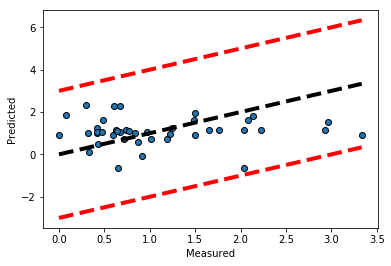

In [415]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
predicted = cross_val_predict(reg, features, labels, cv=10)
y=labels
fig, ax = plt.subplots()
ax.scatter(labels, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.plot([y.min(), y.max()], [y.min()+drawpiclim, y.max()+drawpiclim], 'r--', lw=4)
ax.plot([y.min(), y.max()], [y.min()-drawpiclim, y.max()-drawpiclim], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [416]:
#Multi-layer Perceptron regressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

tuned_parameters = [{ 'learning_rate_init': [0.001,0.005,0.01],
                     'activation': ['relu','tanh','logistic']}]
mlp= MLPRegressor(hidden_layer_sizes=(100, 100),
                                 learning_rate_init=0.01,
                                 early_stopping=True)
mlp = GridSearchCV(mlp, tuned_parameters, scoring=None, cv=cv, n_jobs=16)
mlp.fit(X_train, y_train)
mlp_new = mlp.best_estimator_
best_p = mlp.best_params_
paras = mlp_new.get_params()
print(best_p)


{'activation': 'relu', 'learning_rate_init': 0.01}


In [417]:
mse = mean_squared_error(y_test, mlp_new.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
y_pred = mlp_new.predict(X_test)
r2_score(y_test, y_pred)
print("The R2 on test set: {:.4f}".format(r2_score(y_test, y_pred)))
print("The MAE on test set: {:.4f}".format(mean_absolute_error(y_test, y_pred)))
from sklearn.metrics import explained_variance_score
print("The  explained variance regression score on test set: {:.8f}".format(explained_variance_score(y_test, y_pred, multioutput='uniform_average')))

The mean squared error (MSE) on test set: 0.4957
The R2 on test set: -0.1393
The MAE on test set: 0.5175
The  explained variance regression score on test set: 0.03918247


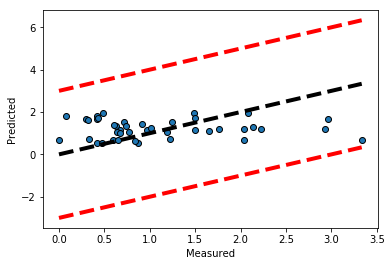

In [418]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
predicted = cross_val_predict(mlp_new, features, labels, cv=10)
y=labels
fig, ax = plt.subplots()
ax.scatter(labels, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.plot([y.min(), y.max()], [y.min()+drawpiclim, y.max()+drawpiclim], 'r--', lw=4)
ax.plot([y.min(), y.max()], [y.min()-drawpiclim, y.max()-drawpiclim], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()